In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

df = pd.read_csv('df_all_fights(1).csv')
df.columns = df.columns.str.strip() 

stat_features = [
    'strike_accuracy_diff',
    'total_strike_accuracy_diff',
    'knockdowns_diff',
    'takedown_accuracy_diff',
    'takedowns_diff',
    'submission_attempts_diff'
]

meta_features = ['weight_class', 'method']

df_clean = df[stat_features + meta_features].dropna()


X_win = df_clean.copy()
y_win = np.ones(X_win.shape[0])

X_lose = df_clean.copy()
X_lose[stat_features] = -X_lose[stat_features]
y_lose = np.zeros(X_lose.shape[0])

X_combined = pd.concat([X_win, X_lose], axis=0).reset_index(drop=True)
y_combined = np.concatenate([y_win, y_lose])


transformer = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), stat_features),
        ('encoder', OneHotEncoder(handle_unknown='ignore'), meta_features)
    ]
)

model_dict = {
    'Naive Bayes': GaussianNB(),
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5, weights='distance'),  # might tweak this later
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

for model_name, classifier in model_dict.items():
    print(f"\nModel: {model_name}")

    model_pipeline = Pipeline([
        ('prep', transformer),
        ('oversample', SMOTE(random_state=42)),
        ('classifier', classifier)
    ])

    y_pred = cross_val_predict(model_pipeline, X_combined, y_combined, cv=5, n_jobs=-1)

    print(classification_report(y_combined, y_pred, digits=3))


Model: Naive Bayes
              precision    recall  f1-score   support

         0.0      0.768     0.768     0.768      1545
         1.0      0.768     0.768     0.768      1545

    accuracy                          0.768      3090
   macro avg      0.768     0.768     0.768      3090
weighted avg      0.768     0.768     0.768      3090


Model: k-Nearest Neighbors
              precision    recall  f1-score   support

         0.0      0.801     0.801     0.801      1545
         1.0      0.801     0.801     0.801      1545

    accuracy                          0.801      3090
   macro avg      0.801     0.801     0.801      3090
weighted avg      0.801     0.801     0.801      3090


Model: Random Forest
              precision    recall  f1-score   support

         0.0      0.824     0.825     0.824      1545
         1.0      0.825     0.823     0.824      1545

    accuracy                          0.824      3090
   macro avg      0.824     0.824     0.824      3090
weig

scale__strike_accuracy_diff          0.217133
scale__total_strike_accuracy_diff    0.199530
scale__knockdowns_diff               0.127472
scale__takedown_accuracy_diff        0.113522
scale__submission_attempts_diff      0.089664
scale__takedowns_diff                0.083341
encode__method_submission            0.030059
encode__method_decision_unanimous    0.019250
dtype: float64


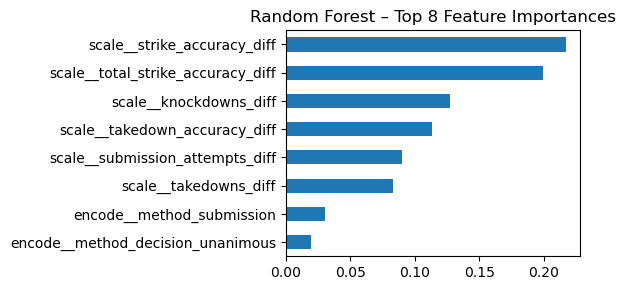

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('xform',
                                                  ColumnTransformer(transformers=[('scale',
                                                                                   StandardScaler(),
                                                                                   ['strike_accuracy_diff',
                                                                                    'total_strike_accuracy_diff',
                                                                                    'knockdowns_diff',
                                                                                    'takedown_accuracy_diff',
                                                                                    'takedowns_diff',
                                                                                    'submission_attempts_diff']),
                                                                                  ('encode',
                                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                                   ['weight_class',
                                                                                    'method'])])),
                                                 ('rf',
                                                  RandomForestClassifier(random_state=42))]))

In [12]:
feat_transform = ColumnTransformer([
    ('scale',  StandardScaler(), num_cols),
    ('encode', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

pipe_rf = Pipeline([
    ('xform', feat_transform),
    ('rf',   RandomForestClassifier(n_estimators=100, random_state=42))
])

pipe_rf.fit(X_total, y_total)          

rf         = pipe_rf.named_steps['rf']
pre        = pipe_rf.named_steps['xform']
feat_names = pre.get_feature_names_out()

importances = (pd.Series(rf.feature_importances_, index=feat_names)
                 .sort_values(ascending=False))

print(importances.head(8))
importances.head(8).plot.barh(figsize=(6,3))
plt.gca().invert_yaxis()
plt.title("Random Forest – Top 8 Feature Importances")
plt.tight_layout(); plt.show()

cal_rf = CalibratedClassifierCV(estimator=pipe_rf, method='sigmoid', cv=5)
cal_rf.fit(X_total, y_total)       


In [9]:
# average F1
f1_list = [0.76, 0.83, 0.85, 0.81]
print("Mean F1 =", round(sum(f1_list)/len(f1_list), 4))


Mean F1 = 0.8125
